In this notebook, we will create `TfRecords` from the 512x512 resized images from `nb_00`.

Source: 
- [TensorFlow Docs](https://www.tensorflow.org/tutorials/load_data/tfrecord)
- [How To Create TFRecords by Cdeotte](https://www.kaggle.com/cdeotte/how-to-create-tfrecords/#data)

In [1]:
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
import tensorflow as tf, re, math
from pathlib import Path
from PIL import Image

In [2]:
PATH = '../data/train_512x512/'
TRN_DF = pd.read_csv('../data/train.csv')

# set this to True if TFRecords haven't been created
CREATE_TF_RECORD = False

In [3]:
# from TF docs
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
IMG_PATHS = [os.path.join(PATH, id[0], id[1], id[2], id+'.jpg') for id in TRN_DF.id]
TARGETS   = TRN_DF.landmark_id.values.tolist()
IMG_PATHS[:4], TARGETS[:4]

(['../data/train_512x512/1/7/6/17660ef415d37059.jpg',
  '../data/train_512x512/9/2/b/92b6290d571448f6.jpg',
  '../data/train_512x512/c/d/4/cd41bf948edc0340.jpg',
  '../data/train_512x512/f/b/0/fb09f1e98c6d2f70.jpg'],
 [1, 1, 1, 1])

In [5]:
def serialize_example(feature0, feature1, feature2):
  feature = {
      'image': _bytes_feature(feature0),
      'img_path': _bytes_feature(feature1),
      'target': _int64_feature(feature2)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [6]:
SIZE = 4000
CT = len(IMG_PATHS)//SIZE + int(len(IMG_PATHS)%SIZE!=0)
CT

396

In [7]:
%%time
# this script takes around 3 hours to run
if CREATE_TF_RECORD:
    for j in range(CT):
        print(); print('Writing TFRecord %i of %i...'%(j,CT))
        CT2 = min(SIZE,len(IMG_PATHS)-j*SIZE)
        with tf.io.TFRecordWriter('train%.2i-%i.tfrec'%(j,CT2)) as writer:
            for k in range(CT2):
                img = cv2.imread(IMG_PATHS[SIZE*j+k])
#                 img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
                target = TARGETS[SIZE*j+k]
                example = serialize_example(
                    img, 
                    str.encode(Path(IMG_PATHS[SIZE*j+k]).stem), 
                    target
                )
                writer.write(example)
                if k%100==0: print(k,', ',end='')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


**Validate TFRecords**

In [8]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

In [9]:
def batch_to_numpy_images_and_labels(data):
    images, paths, labels = data
    numpy_images = images.numpy()
    numpy_paths = paths.numpy()
    numpy_labels = labels.numpy()

    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_paths, numpy_labels

In [10]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

In [11]:
def display_one_landmark(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [12]:
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, paths, labels = batch_to_numpy_images_and_labels(databatch)

    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, path, label) in enumerate(zip(images[:rows*cols], paths[:rows*cols], labels[:rows*cols])):
        title = path.decode() + ' | ' + str(label)
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_landmark(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "img_path": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    path  = example['img_path']
    label = example['target']
    return image, path, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. landmarks00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [512,512]; BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('./train*.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))

There are 4000 train images


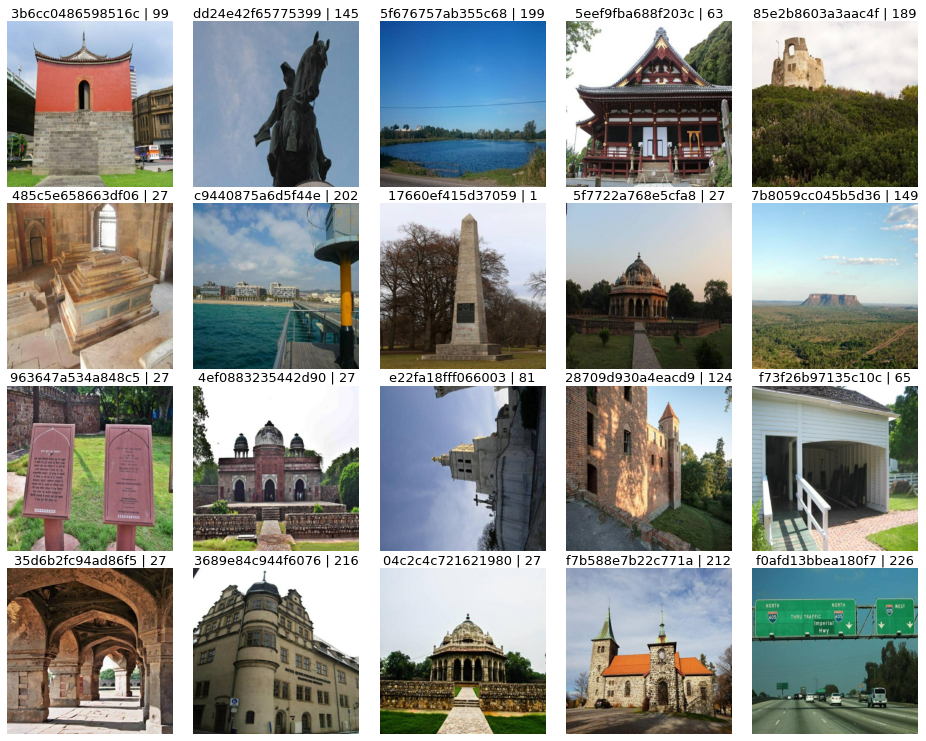

In [15]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))